# ATUA 2026: (Multiscale) Geographically Weighted Regression

### GWR and MGWR examples
***
This is a basic example notebook demonstrate how to calibrate a GWR or an MGWR model.

#### Installation

In case you may need to install the `mgwr` package in your spatial regression environment:


`pip install mgwr`

In [ ]:
#pip install mgwr

Load packages

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
import pandas as pd
import libpysal as ps 
from libpysal.weights import Queen
from esda.moran import Moran
import statsmodels.api as sm

# MGWR functions
from mgwr.gwr import GWR,MGWR
from mgwr.sel_bw import Sel_BW

Load voting dataset in the U.S.

The dataset we will be using is the 2020 election voting data at the county level together with socio-economic data from Census Bureau's American Community Survey (ACS).

The problem of interest is: counties with what type of socio-economic profile will lean towards voting for the demotractic/republican party?

In [3]:
voting = pd.read_csv(r'Data/voting_2021.csv')

voting[['median_income']] = voting[['median_income']]/10000

In [41]:
voting.shape

(3108, 22)

In [17]:
voting.head()

,county_id,state,county,NAME,proj_X,proj_Y,total_pop,new_pct_dem,sex_ratio,pct_black,...,median_income,pct_65_over,pct_age_18_29,gini,pct_manuf,ln_pop_den,pct_3rd_party,turn_out,pct_fb,pct_uninsured
0,17051,17,51,"Fayette County, Illinois",597980.182064,1.796863e+06,21565,18.479911,113.6,4.7,...,4.6650,18.8,14.899142,0.4373,14.9,3.392748,1.740255,59.066079,1.3,8.2
1,17107,17,107,"Logan County, Illinois",559815.813333,1.920479e+06,29003,29.593095,97.2,6.9,...,5.7308,18.0,17.256835,0.4201,12.4,3.847163,2.392057,57.395734,1.6,4.5
2,17165,17,165,"Saline County, Illinois",650277.214895,1.660710e+06,23994,25.605949,96.9,2.6,...,4.4090,19.9,13.586730,0.4692,8.7,4.128731,1.572384,59.078533,1.0,4.2
3,17097,17,97,"Lake County, Illinois",654006.840698,2.174577e+06,701473,62.275888,99.8,6.8,...,8.9427,13.7,15.823132,0.4847,16.3,7.308582,1.960338,71.156446,18.7,6.8
4,17127,17,127,"Massac County, Illinois",640398.986258,1.599902e+06,14219,25.662005,89.5,5.8,...,4.7481,20.8,12.370772,0.4097,7.4,4.067788,1.335682,62.372974,1.0,5.4


In [4]:
shp = gpd.read_file(r'Data/us_counties.geojson')

In [20]:
shp.head()

,GEOID,STATEFP,NAME,county_id,geometry
0,37017,37,Bladen,37017,"POLYGON ((1542624.564 1447518.25861, 1551448.7..."
1,37167,37,Stanly,37167,"POLYGON ((1393365.57999 1463317.09569, 1405814..."
2,39153,39,Summit,39153,"POLYGON ((1187539.95372 2103811.07817, 1185335..."
3,42113,42,Sullivan,42113,"POLYGON ((1576879.76977 2224763.14827, 1626097..."
4,48459,48,Upshur,48459,"POLYGON ((79020.44409 1065817.40446, 78838.627..."


In [ ]:
# Merge the shapefile with the voting data by the common county_id
shp_voting = shp.merge(voting, on ="county_id")

# Dissolve the counties to obtain boundary of states, used for mapping
state = shp_voting.dissolve(by='STATEFP').geometry.boundary

In [ ]:
# Select the dependent variable and independent variables for GWR/MGWR
# The dependent variable is the percentage of Democratic votes in 2020 (new_pct_dem).
# We selected a few independent variables to fit this model. 
variable_names = ['sex_ratio', 'pct_black', 'pct_hisp',
                  'pct_bach', 'median_income','ln_pop_den']


y = shp_voting[['new_pct_dem']].values

X = shp_voting[variable_names].values

In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Ensure you have a constant (intercept) for the VIF calculation
# VIF is usually calculated with an intercept to get accurate results
X_df = shp_voting[variable_names].copy()
X_df['intercept'] = 1

# Calculate VIF for each variable
vif_data = pd.DataFrame()
vif_data["feature"] = X_df.columns
vif_data["VIF"] = [variance_inflation_factor(X_df.values, i) 
                          for i in range(len(X_df.columns))]

# View the results (excluding the intercept row for clarity)
print(vif_data[vif_data['feature'] != 'intercept'])

         feature       VIF
0      sex_ratio  1.133135
1      pct_black  1.253777
2       pct_hisp  1.031957
3       pct_bach  2.249431
4  median_income  2.338215
5     ln_pop_den  1.506674


Often in GWR or MGWR, we suggest to standardize both the independent and the dependent variables. 

By standardizing, here it means we substract the mean and divided by the standard deviation.

The benefit of this approach is that the coefficients obtained become "unit-free," allowing for comparison of variable importance across variables and locations.

You can also unstandardize the coefficients by following some simple maths (you can ask AI if you want)

In [7]:
X = (X - X.mean(axis=0))/X.std(axis=0)
y = (y - y.mean(axis=0))/y.std(axis=0)

We need the coordinates to put into GWR.

Make sure you are using projected coordinates.

In [8]:
coords = shp_voting[['proj_X', 'proj_Y']].values

OLS regression, regression residual map, and global moran's I of regression residuals. 

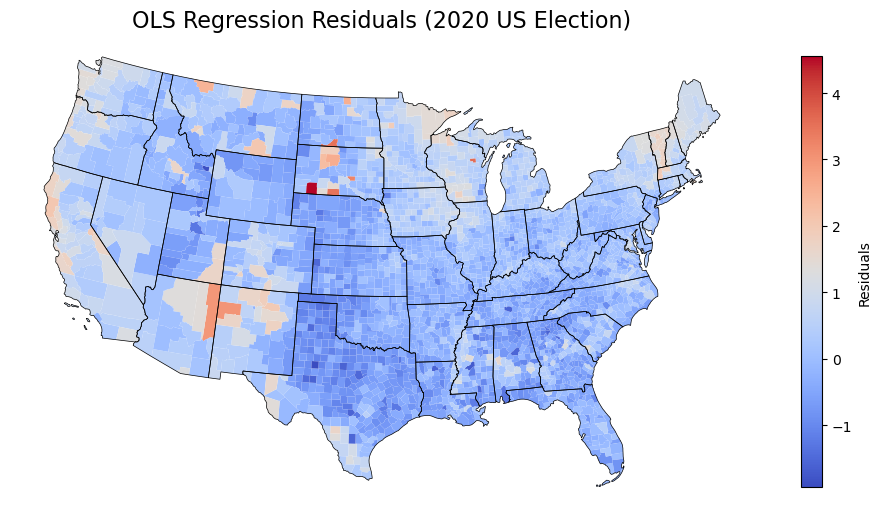

/var/folders/4h/m4wxtk6x2v78kzl8pqqnfdnc0000gp/T/ipykernel_27978/395128245.py:33: FutureWarning: `use_index` defaults to False but will default to True in future. Set True/False directly to control this behavior and silence this warning
  w = Queen.from_dataframe(shp_voting)
/Users/qzhao/opt/anaconda3/envs/regression/lib/python3.14/site-packages/libpysal/weights/contiguity.py:347: UserWarning: The weights matrix is not fully connected: 
 There are 3 disconnected components.
 There are 2 islands with ids: 2443, 2703.
  W.__init__(self, neighbors, ids=ids, **kw)


('WARNING: ', 2443, ' is an island (no neighbors)')
('WARNING: ', 2703, ' is an island (no neighbors)')
Global Moran's I for OLS residuals: 0.6020
Expected value (E[I]): -0.0003
p-value (pseudo-significance): 0.00100


In [ ]:
# Fit the Global OLS model
# We add a constant (intercept) to the independent variables
X_ols = sm.add_constant(X)
ols_model = sm.OLS(y, X_ols).fit()

# Extract residuals and assign them to the GeoDataFrame
shp_voting['ols_resid'] = ols_model.resid

# Visualize the OLS residuals
fig, ax = plt.subplots(1, 1, figsize=(12, 8))

# Plot the residuals
shp_voting.plot(column='ols_resid', 
                cmap='coolwarm', 
                legend=True, 
                ax=ax, 
                edgecolor='none',
                legend_kwds={'label': "Residuals", 'shrink': 0.7})

# Overlay the state boundaries for better context
state.plot(ax=ax, edgecolor='black', facecolor='none', linewidth=0.5)

ax.set_title('OLS Regression Residuals (2020 US Election)', fontsize=16)
ax.set_axis_off()
plt.show()

# Calculate Global Moran's I for the OLS residuals
# Create a Queen contiguity spatial weights matrix from the county geometries
w = Queen.from_dataframe(shp_voting)
w.transform = 'r'  # Row-standardize the weights

# Calculate the Moran's I statistic
moran_ols = Moran(shp_voting['ols_resid'], w)

print(f"Global Moran's I for OLS residuals: {moran_ols.I:.4f}")
print(f"Expected value (E[I]): {moran_ols.EI:.4f}")
print(f"p-value (pseudo-significance): {moran_ols.p_sim:.5f}")

#### Fit a GWR model in two steps
- Select the optimal bandwidths
- Use the optimal bandwidth to fit the GWR model
***
The default kernel is adaptive (# of nearest neighbors) bisquare.

In [9]:
%%time

gwr_selector = Sel_BW(coords, y, X,)

gwr_bw = gwr_selector.search(verbose=True,criterion='AICc')

print("Selected optimal bandwidth is:", gwr_bw)

Bandwidth:  1221.0 , score:  4033.85
Bandwidth:  1941.0 , score:  4597.80
Bandwidth:  775.0 , score:  3521.60
Bandwidth:  500.0 , score:  3095.52
Bandwidth:  329.0 , score:  2746.91
Bandwidth:  224.0 , score:  2469.38
Bandwidth:  159.0 , score:  2310.58
Bandwidth:  119.0 , score:  2245.74
Bandwidth:  94.0 , score:  2225.30
Bandwidth:  79.0 , score:  2232.10
Bandwidth:  104.0 , score:  2230.35
Bandwidth:  89.0 , score:  2222.88
Bandwidth:  85.0 , score:  2223.03
Bandwidth:  91.0 , score:  2223.30
Bandwidth:  87.0 , score:  2225.73
Selected optimal bandwidth is: 89.0
CPU times: user 4.64 s, sys: 1.26 s, total: 5.9 s
Wall time: 19.8 s


The algorithm uses a optimization stragety to find the optimal bandwidth that gives the best score, in this case, the lowest AICc. The selected optimal bandwidth is 89 and we used the adaptive bisquare kernel, which mean that 89 nearest neighbors used for each local regression (same bandwidth for all the parameters). 

Fit the model using the optimal bw

In [22]:
# Fit the GWR model with the selected bandwidth
gwr_results = GWR(coords, y, X, bw=gwr_bw,name_x=variable_names).fit()

Summary of GWR outputs. The outputs starts with an OLS model, then followed by GWR results. You do not need to fit an OLS model separately, but make sure you check the R2, AICc, and VIF before you move to the GWR. 

In [23]:
gwr_results.summary()

Model type                                                         Gaussian
Number of observations:                                                3108
Number of covariates:                                                     7

Global Regression Results
---------------------------------------------------------------------------
Residual sum of squares:                                           1209.887
Log-likelihood:                                                   -2943.936
AIC:                                                               5901.873
AICc:                                                              5903.919
BIC:                                                             -23727.532
R2:                                                                   0.611
Adj. R2:                                                              0.610

Variable                              Est.         SE  t(Est/SE)    p-value
------------------------------- ---------- ---------- ------

The local estimates can be obtained from `gwr_results.params`, which returns you a n by (1+p) array where p is the number of predictors in the model plus the intercept.

In [27]:
variable_names

['sex_ratio',
 'pct_black',
 'pct_hisp',
 'pct_bach',
 'median_income',
 'ln_pop_den']

In [29]:
gwr_results.params[:,4] #this will give you location-specific coefficient for pct_bach

array([ 0.5650606 ,  0.61548093,  0.42173768, ..., -0.08772565,
        0.75517883,  0.39387276], shape=(3108,))

Text(0.5, 1.0, 'Coefficients of pct_bach')

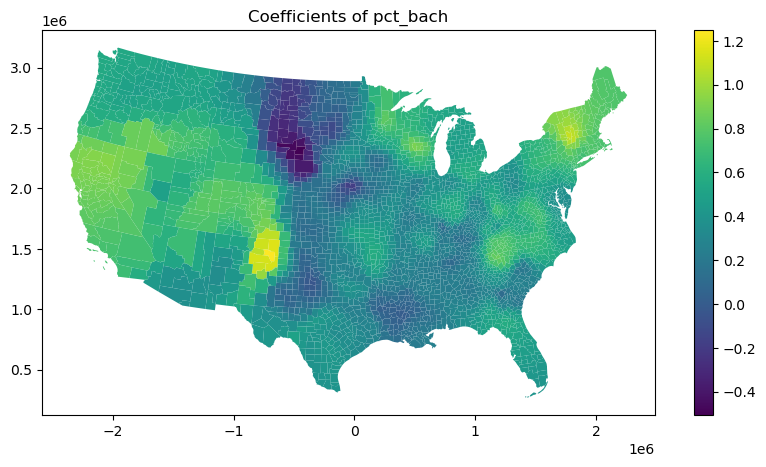

In [30]:
from matplotlib import colors

ax = shp_voting.plot(column=gwr_results.params[:,4],figsize=(10,5),legend=True, 
                     linewidth=0.0,aspect=1)

plt.title("Coefficients of " + variable_names[3] ,fontsize=12)

Write some mapping codes to visualize the parameter estimate surfaces altogether. We need to join the GWR result with the county GeoDataFrame.

In [ ]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mgwr.utils import shift_colormap,truncate_colormap
from matplotlib import cm,colors

def param_plots(result, gdf, names=[], filter_t=False, vfigsize=(10, 10)):
    
    #Size of the plot. Here we have a 2 by 2 layout.
    k = gwr_results.k
    
    fig, axs = plt.subplots(int(k/2)+1, 2, figsize=figsize)
    axs = axs.ravel()
    
    #The max and min values of the color bar.
    vmin = -0.8
    vmax = 0.8
    
    cmap = cm.get_cmap("bwr_r")
    norm = colors.BoundaryNorm(np.arange(-0.8,0.9,0.1),ncolors=256)
    
    for j in range(k):
        
        pd.concat([gdf,pd.DataFrame(np.hstack([result.params,result.bse]))],axis=1).plot(ax=axs[j],column=j,vmin=vmin,vmax=vmax,
                                                                                         cmap=cmap,norm=norm,linewidth=0.1,edgecolor='white',aspect=1)
        axs[j].set_title("Parameter estimates of \n" + names[j],fontsize=10)
        
        if filter_t:
            rslt_filtered_t = result.filter_tvals()
            if (rslt_filtered_t[:,j] == 0).any():
                gdf[rslt_filtered_t[:,j] == 0].plot(color='lightgrey', ax=axs[j],linewidth=0.1,edgecolor='white',aspect=1)
        
        plt.axis('off')
    
    fig = axs[j].get_figure()
    cax = fig.add_axes([0.99, 0.2, 0.025, 0.6])
    sm = plt.cm.ScalarMappable(cmap=cmap,norm=norm)
    # fake up the array of the scalar mappable. Urgh...
    sm._A = []
    fig.colorbar(sm, cax=cax)

#### Here are the maps of parameter estimates obtained from GWR. Each represent the spatial relationship between each predictor and Voting results.

- Positive (negative) relationships are shown in red (blue).
- Stronger (weaker) relationship has a darker (lighter) color.

/var/folders/4h/m4wxtk6x2v78kzl8pqqnfdnc0000gp/T/ipykernel_27978/1374554983.py:17: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("bwr_r")


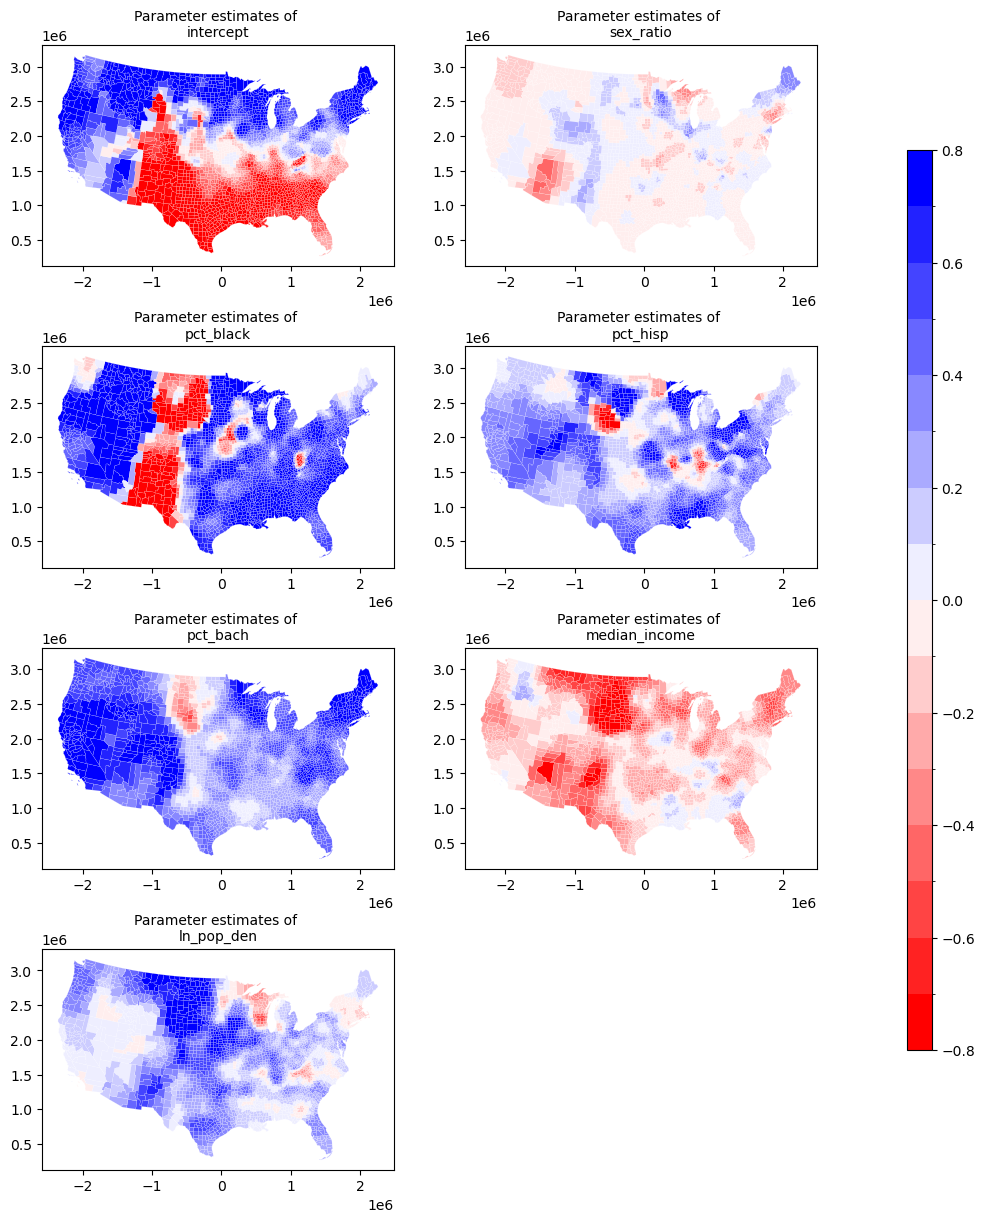

In [32]:
param_plots(gwr_results, shp_voting, names=['intercept'] + variable_names,figsize = (10,15))

Now let's checkout the residuals of from the GWR model.

In [33]:
#Here we use the Queen contiguity
w = Queen.from_dataframe(shp_voting)

#row standardization
w.transform = 'R'

residual_moran = Moran(gwr_results.resid_response.reshape(-1), w)
residual_moran.I

/var/folders/4h/m4wxtk6x2v78kzl8pqqnfdnc0000gp/T/ipykernel_27978/2963299590.py:2: FutureWarning: `use_index` defaults to False but will default to True in future. Set True/False directly to control this behavior and silence this warning
  w = Queen.from_dataframe(shp_voting)


('WARNING: ', 2443, ' is an island (no neighbors)')
('WARNING: ', 2703, ' is an island (no neighbors)')


/Users/qzhao/opt/anaconda3/envs/regression/lib/python3.14/site-packages/libpysal/weights/contiguity.py:347: UserWarning: The weights matrix is not fully connected: 
 There are 3 disconnected components.
 There are 2 islands with ids: 2443, 2703.
  W.__init__(self, neighbors, ids=ids, **kw)


np.float64(0.11410885823498396)

Often, we observe that the residuals from the GWR model have much lower Moran's I values, indicating that spatial structure has been accounted for. The local intercept serves as an intrinsic contextual effect, indicating, for example, how much influence can be attributed to the "location" alone.



### GWR inference

Local coefficient significance

#### Here are the maps of **SIGNIFICANT (p<0.05)** parameter estimates. The significance test has been adjusted to account for the multiple testing issue. 

Insinificant parameters are masked out in grey. 

This is done by the `result.filter_tvals()` in the `param_plots()` function.


/var/folders/4h/m4wxtk6x2v78kzl8pqqnfdnc0000gp/T/ipykernel_27978/1374554983.py:17: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("bwr_r")


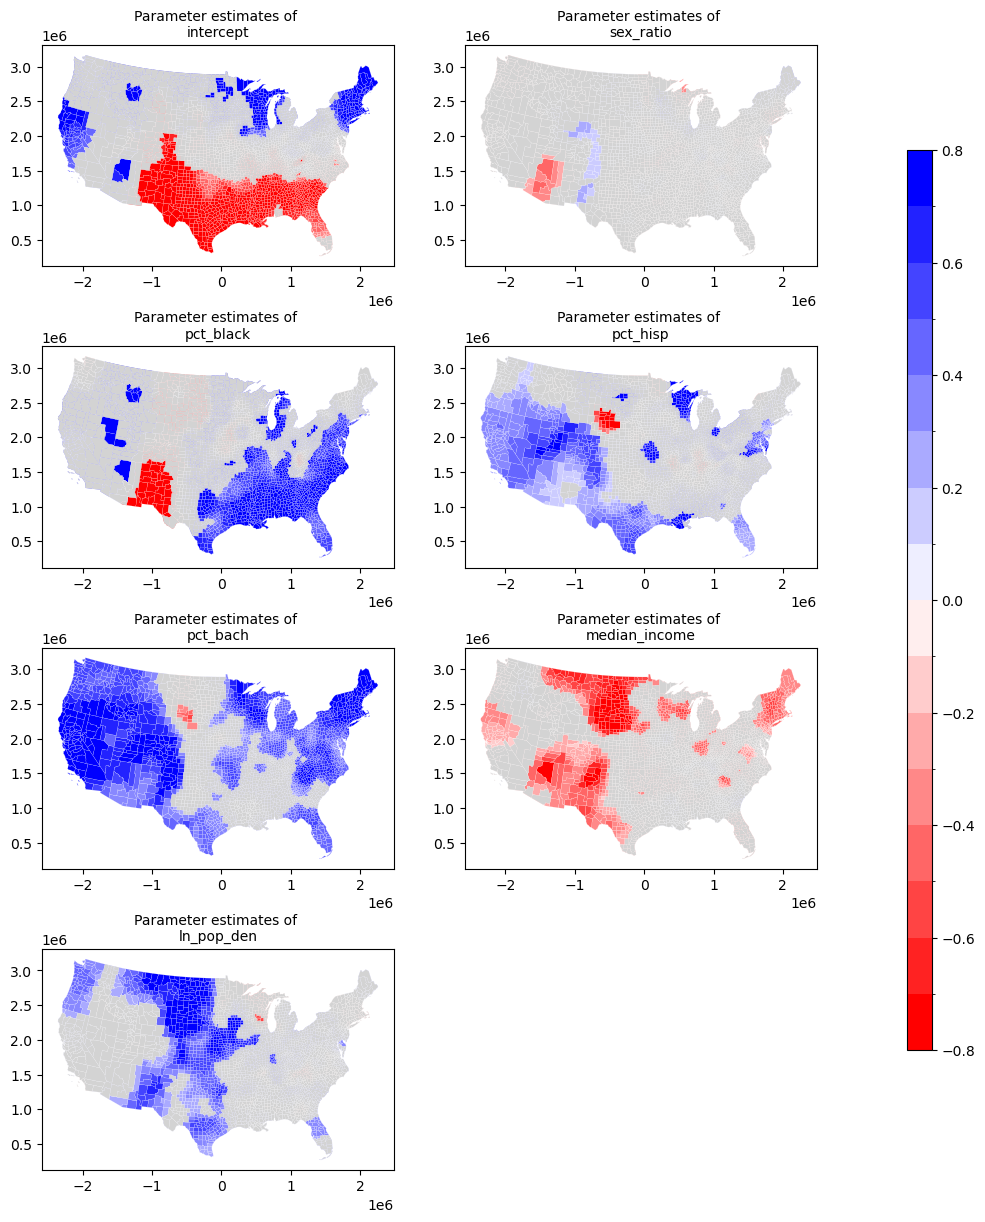

In [34]:
param_plots(gwr_results, shp_voting, names=['intercept'] + variable_names, figsize = (10,15), filter_t=True)

We find after we adjust the maps for both p-values and multiple testing, many of the patterns go away (are not significant)

#### Fit an MGWR model in two steps
- Search for the optimal bandwidths
- Use the optimal bandwidths to fit the MGWR model
***

**Note**: MGWR can be VERY slow when the data is beyond 3,000 records. The bandwidth search needs to find the optimal bandwidth for each of the parameters. 

The `%%time` cell magic can record the time taken for the cell to finish.

In [ ]:
%%time
mgwr_selector = Sel_BW(coords, y, X, multi=True)
mgwr_bw = mgwr_selector.search(verbose=True)

print("Selected optimal bandwidth is:", mgwr_bw)

Current iteration: 1 ,SOC: 0.0054039
Bandwidths: 44.0, 173.0, 44.0, 44.0, 77.0, 46.0, 46.0
Current iteration: 2 ,SOC: 0.0025988
Bandwidths: 44.0, 445.0, 44.0, 54.0, 86.0, 44.0, 52.0
Current iteration: 3 ,SOC: 0.0017628
Bandwidths: 44.0, 707.0, 44.0, 77.0, 92.0, 44.0, 77.0
Current iteration: 4 ,SOC: 0.0014031
Bandwidths: 44.0, 1269.0, 44.0, 104.0, 100.0, 44.0, 113.0
Current iteration: 5 ,SOC: 0.0011663
Bandwidths: 44.0, 1397.0, 44.0, 131.0, 117.0, 44.0, 131.0
Current iteration: 6 ,SOC: 0.0010009
Bandwidths: 44.0, 1473.0, 44.0, 160.0, 117.0, 44.0, 154.0
Current iteration: 7 ,SOC: 0.0009015
Bandwidths: 44.0, 1585.0, 44.0, 225.0, 127.0, 44.0, 161.0
Current iteration: 8 ,SOC: 0.0007707
Bandwidths: 44.0, 1677.0, 44.0, 276.0, 140.0, 44.0, 171.0
Current iteration: 9 ,SOC: 0.0006461
Bandwidths: 44.0, 1677.0, 44.0, 309.0, 153.0, 44.0, 190.0
Current iteration: 10 ,SOC: 0.0005308
Bandwidths: 44.0, 1677.0, 44.0, 349.0, 155.0, 44.0, 194.0
Current iteration: 11 ,SOC: 0.0004407
Bandwidths: 44.0, 1677.

In [37]:
%%time

mgwr_results = MGWR(coords, y, X, selector=mgwr_selector,name_x=variable_names).fit()

CPU times: user 1h 2min 1s, sys: 2min, total: 1h 4min 1s
Wall time: 14min 10s


MGWR summary file, that has OLS first then MGWR. From the results, we have different bandwidth for different parameters. For example, Sex_ratio and pct_hisp have a much larger bandwidth, which represents a more global regression pattern, compared to other variables such as pct_black and median_income, which represents a very local pattern. 

The Adj t-val (95%) is the corrected t-value that you will use for defining significance level. As you can see now it is not longer >1.96 or <-1.96 because of the multiple testing issues of local regression. 

In [38]:
mgwr_results.summary()

Model type                                                         Gaussian
Number of observations:                                                3108
Number of covariates:                                                     7

Global Regression Results
---------------------------------------------------------------------------
Residual sum of squares:                                           1209.887
Log-likelihood:                                                   -2943.936
AIC:                                                               5901.873
AICc:                                                              5903.919
BIC:                                                             -23727.532
R2:                                                                   0.611
Adj. R2:                                                              0.610

Variable                              Est.         SE  t(Est/SE)    p-value
------------------------------- ---------- ---------- ------

In [39]:
#Here we use the Queen contiguity
w = Queen.from_dataframe(shp_voting)

#row standardization
w.transform = 'R'

residual_moran = Moran(mgwr_results.resid_response.reshape(-1), w)
residual_moran.I

/var/folders/4h/m4wxtk6x2v78kzl8pqqnfdnc0000gp/T/ipykernel_27978/3541487640.py:2: FutureWarning: `use_index` defaults to False but will default to True in future. Set True/False directly to control this behavior and silence this warning
  w = Queen.from_dataframe(shp_voting)


('WARNING: ', 2443, ' is an island (no neighbors)')
('WARNING: ', 2703, ' is an island (no neighbors)')


/Users/qzhao/opt/anaconda3/envs/regression/lib/python3.14/site-packages/libpysal/weights/contiguity.py:347: UserWarning: The weights matrix is not fully connected: 
 There are 3 disconnected components.
 There are 2 islands with ids: 2443, 2703.
  W.__init__(self, neighbors, ids=ids, **kw)


np.float64(0.019083237998384326)

Moran's I is reduced to a minimal level.

/var/folders/4h/m4wxtk6x2v78kzl8pqqnfdnc0000gp/T/ipykernel_27978/1374554983.py:17: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("bwr_r")


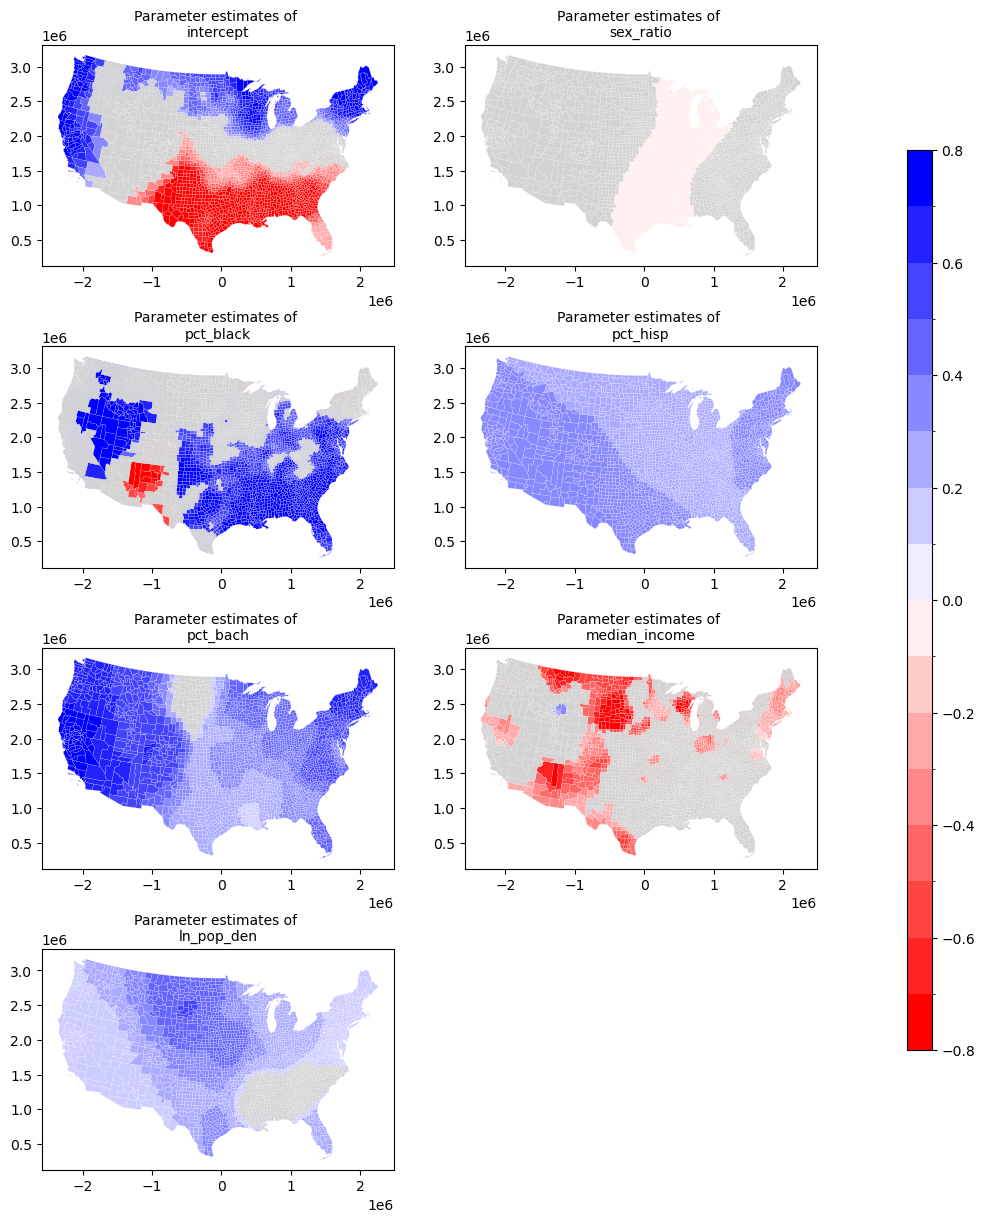

In [40]:
param_plots(mgwr_results, shp_voting, names=['intercept'] + variable_names,figsize = (10,15), filter_t=True)

We can see that the relationships will vary at different spatial scales.

### OLS vs. GWR vs. MGWR

From the comparison, we can clearly see an advantage of MGWR over GWR by allowing the bandwidth to vary across covariates.

| Metric    | OLS    | GWR   | MGWR   |
| -----------  | ----------- | ----------- | ----------- |
| Adjusted R2     | 0.610       | 0.905        | 0.916      |
| AICc    | 5903.9        | 2222.9        | 1748.2      |
| Moran's I of residuals    | 0.60      | 0.11       | 0.019       |
